<a href="https://colab.research.google.com/github/LoganK64/CSCE_489/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Homework 3 </h1>
By: Logan Keim

<h3> Task 1: Create a Dataset for the dataset files </h3>

---



In [ ]:
#pip3 install Cython
#!pip install transformers==3.0.0
from __future__ import print_function, division
from datetime import datetime 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader
import gzip
from google.colab import files
uploaded = files.upload()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
%config InlineBackend.figure_format = 'retina'


class LettersDataset(Dataset):

  def ToTensor(self, sample):
    image, label = sample["image"], sample["label"]
    return (torch.from_numpy(image), torch.tensor(float(label)))

  def __init__(self, data_file, label_file, transform = None):
    self.transform = transform
    with open(data_file,'rb') as f:
      self.num = int.from_bytes(f.read(4),'big')
      self.rows = int.from_bytes(f.read(4), 'big')
      self.cols = int.from_bytes(f.read(4), 'big')
      image_data = f.read()
      self.images = np.frombuffer(image_data, dtype = np.uint8).reshape((self.num, self.rows, self.cols)).astype(np.float32)
    with open(label_file, 'rb') as f:
      num = int.from_bytes(f.read(4),'big')
      label_data = f.read()
      self.labels = np.frombuffer(label_data, dtype = np.uint8)

  def __len__(self):
    return self.num

  def __getitem__(self, idx):
    return self.ToTensor(self.getItemDict(idx))

  def getItemDict(self, index):
    return {"image" : self.images[index], "label" : self.labels[index] -1}

<h3> Task 2: Plot Images From Dataset </h3>

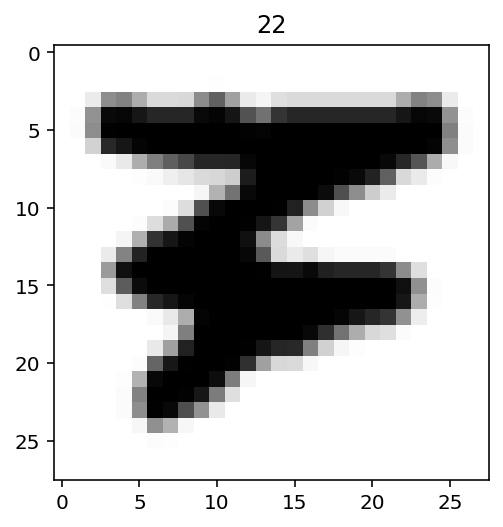

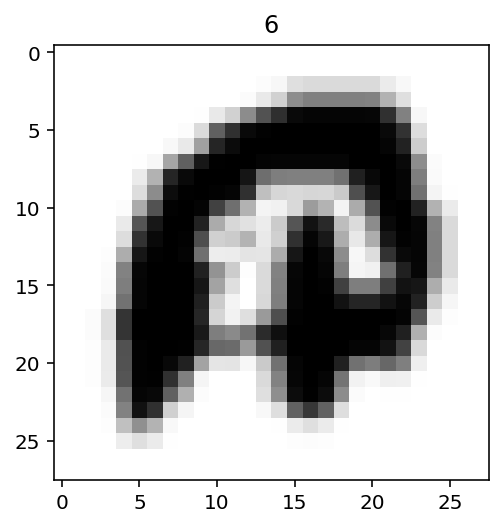

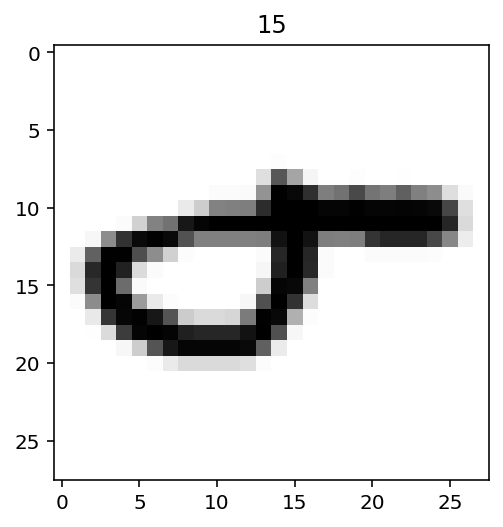

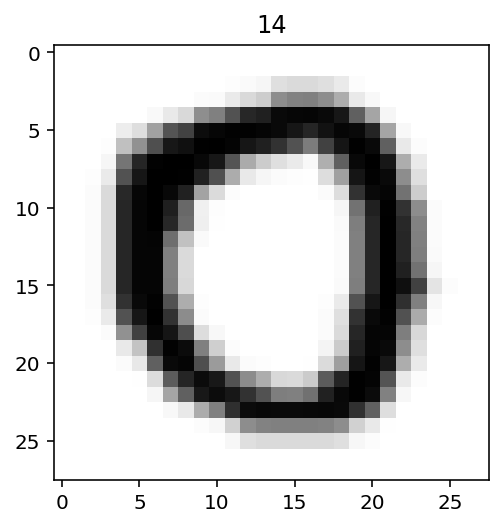

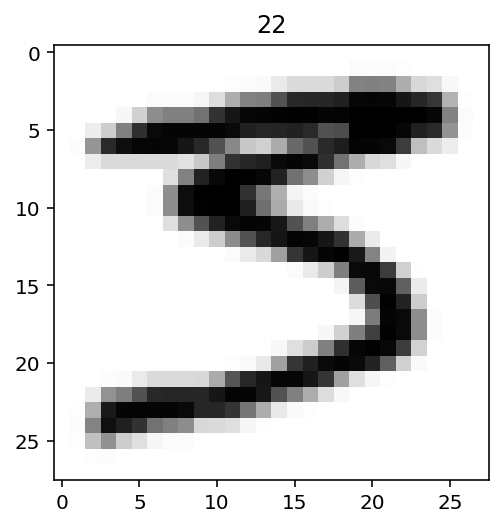

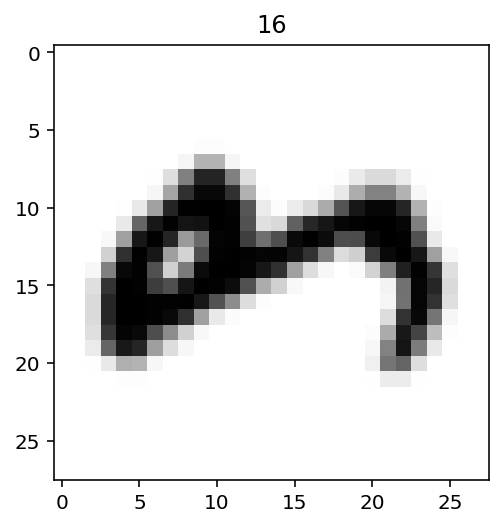

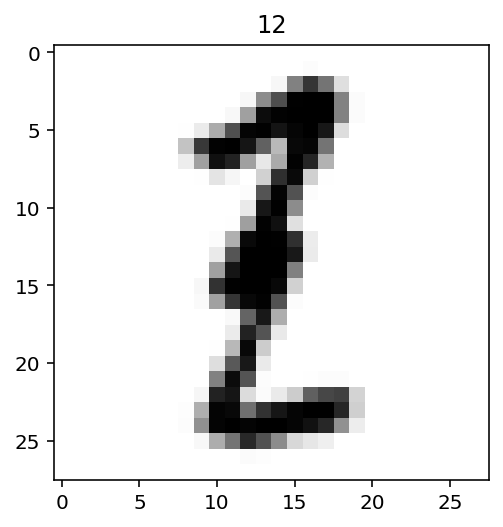

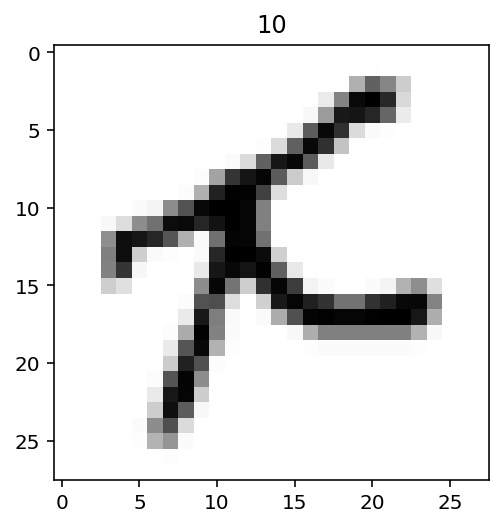

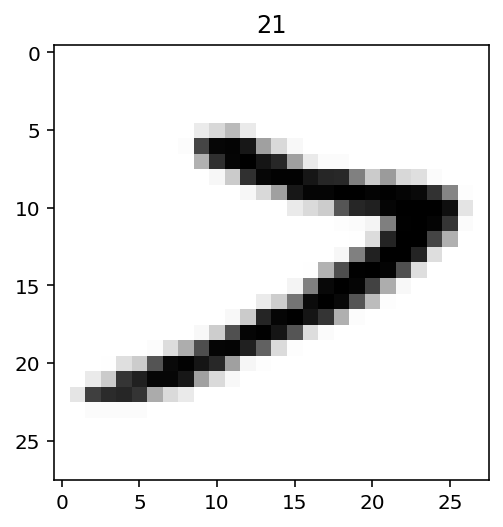

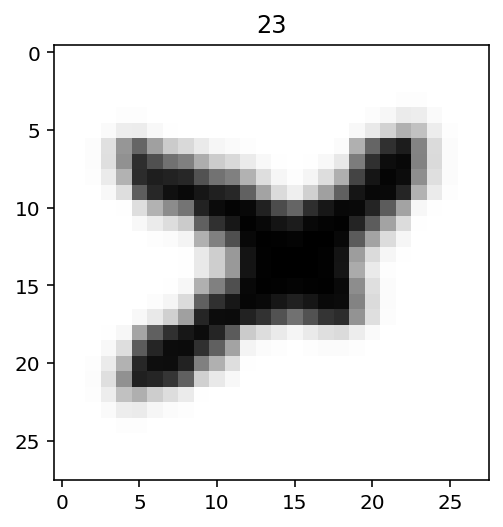

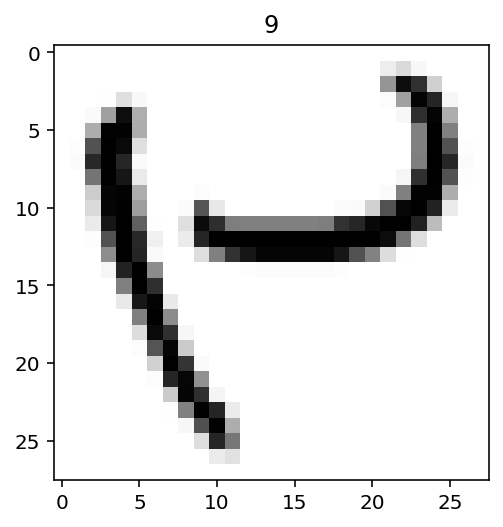

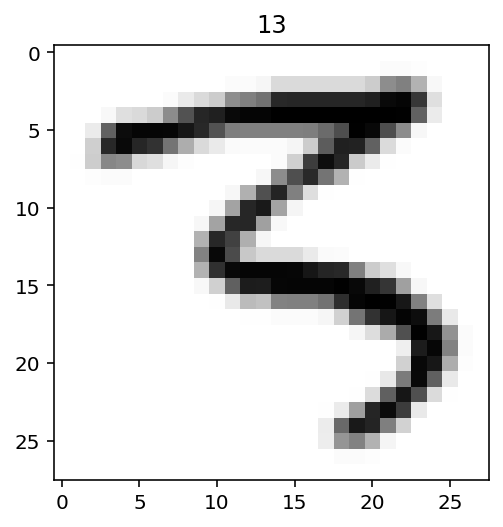

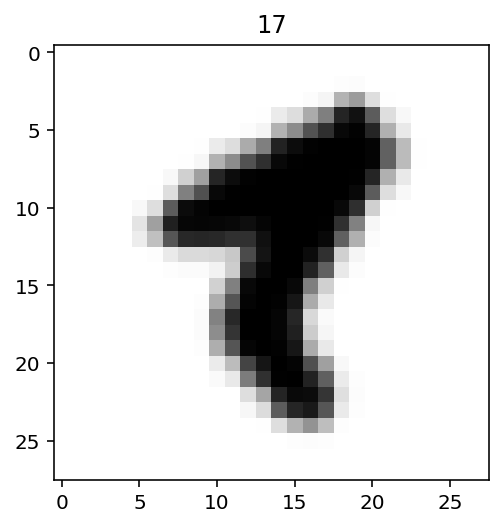

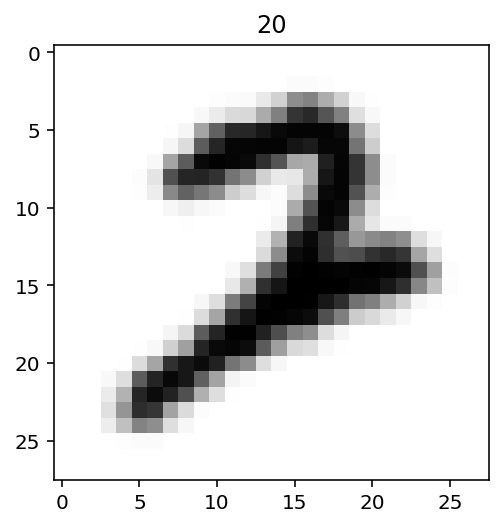

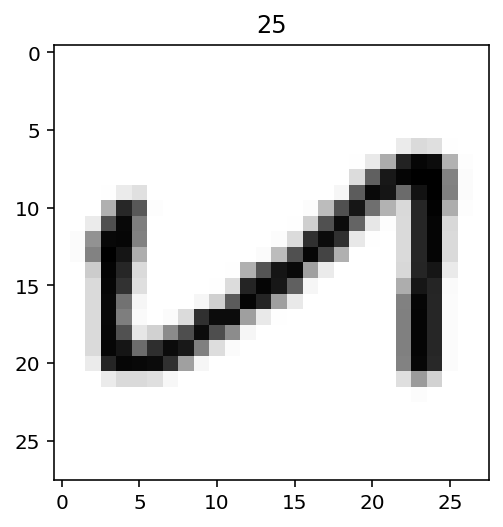

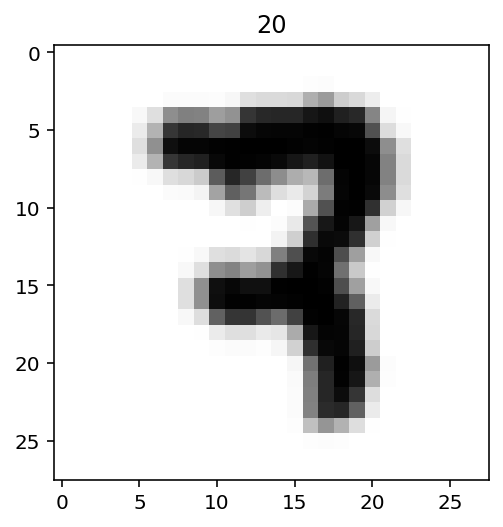

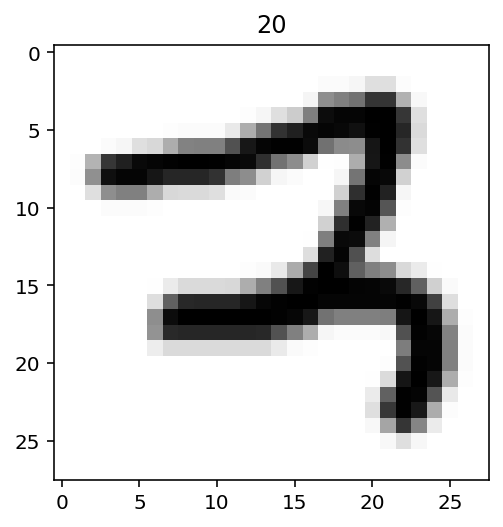

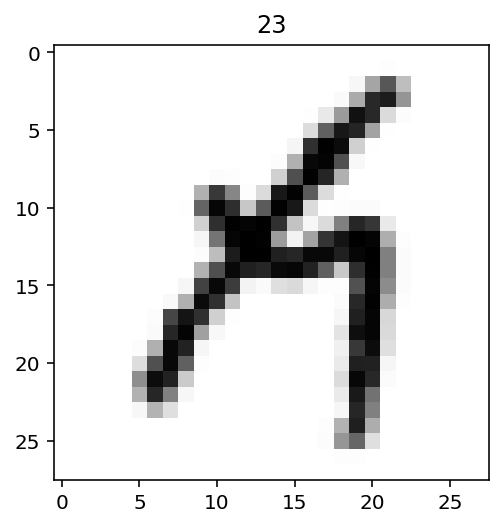

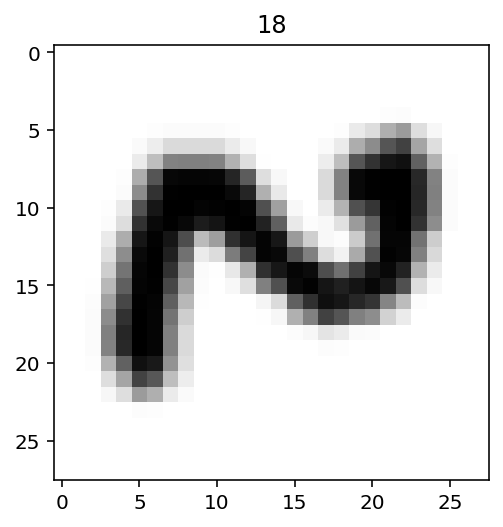

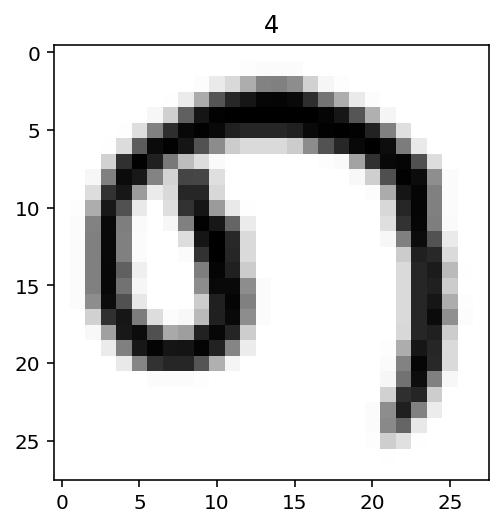

In [ ]:
train_dataset = LettersDataset("hw3-letters-train-images-idx3-ubyte", "hw3-letters-train-labels-idx1-ubyte")
valid_dataset = LettersDataset("hw3-letters-test-images-idx3-ubyte", "hw3-letters-test-labels-idx1-ubyte")
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 28
N_EPOCHS = 15
IMG_SIZE = 28
N_CLASSES = 26
for i in range(20):
  image = train_dataset.getItemDict(i)["image"]
  label = train_dataset.getItemDict(i)["label"]
  plt.imshow(image, cmap = plt.cm.binary)
  plt.title(label)
  plt.show()

<h3> Task 3: Train A CNN to Recognize Letters </h3>

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.unsqueeze(1).float()
            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        X = X.unsqueeze(1).float()
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true.long()) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.unsqueeze(1).float()
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true.long()) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

Define the Neural Network

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

20:07:41 --- Epoch: 0	Train loss: 0.5248	Valid loss: 0.3282	Train accuracy: 90.10	Valid accuracy: 89.62
20:08:15 --- Epoch: 1	Train loss: 0.3013	Valid loss: 0.2959	Train accuracy: 91.21	Valid accuracy: 90.47
20:08:49 --- Epoch: 2	Train loss: 0.2702	Valid loss: 0.2737	Train accuracy: 92.02	Valid accuracy: 91.26
20:09:22 --- Epoch: 3	Train loss: 0.2536	Valid loss: 0.2603	Train accuracy: 92.68	Valid accuracy: 91.65
20:09:56 --- Epoch: 4	Train loss: 0.2423	Valid loss: 0.2722	Train accuracy: 92.33	Valid accuracy: 91.08
20:10:30 --- Epoch: 5	Train loss: 0.2301	Valid loss: 0.2618	Train accuracy: 92.67	Valid accuracy: 91.72
20:11:03 --- Epoch: 6	Train loss: 0.2263	Valid loss: 0.2536	Train accuracy: 92.98	Valid accuracy: 91.60
20:11:37 --- Epoch: 7	Train loss: 0.2193	Valid loss: 0.2582	Train accuracy: 93.03	Valid accuracy: 91.76
20:12:10 --- Epoch: 8	Train loss: 0.2129	Valid loss: 0.2483	Train accuracy: 93.16	Valid accuracy: 92.03
20:12:43 --- Epoch: 9	Train loss: 0.2064	Valid loss: 0.2451	Trai

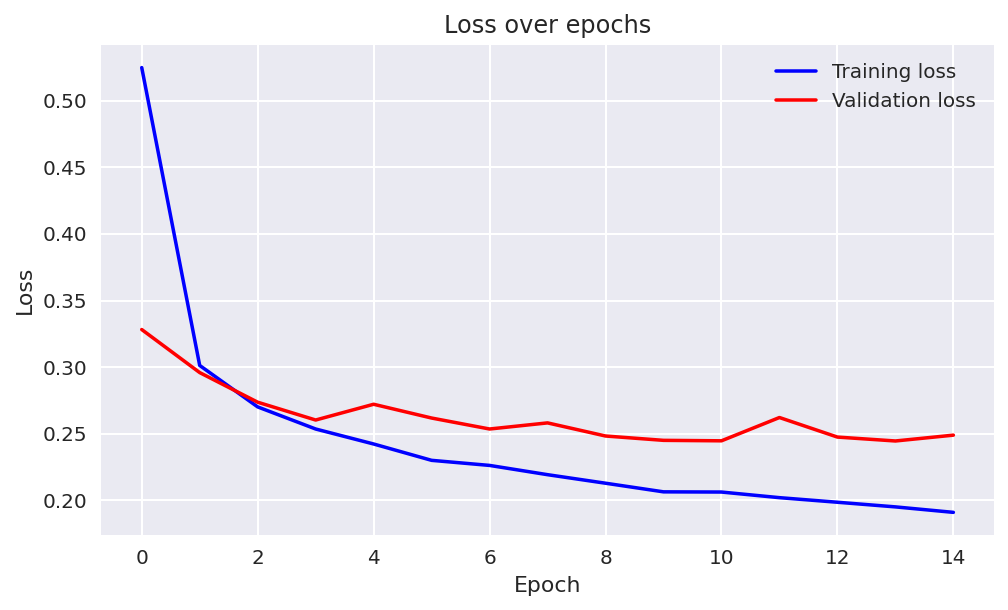

In [ ]:

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

<h3> Task 4: Time to Train with Hardware Accelerator </h3>

In [ ]:
#Training Data While Using a Hardware Accelerator
'''19:08:47 --- Epoch: 0	Train loss: 0.5243	Valid loss: 0.3323	Train accuracy: 89.93	Valid accuracy: 89.47
19:09:22 --- Epoch: 1	Train loss: 0.3035	Valid loss: 0.2955	Train accuracy: 91.17	Valid accuracy: 90.55
19:09:57 --- Epoch: 2	Train loss: 0.2675	Valid loss: 0.2735	Train accuracy: 92.06	Valid accuracy: 91.27
19:10:32 --- Epoch: 3	Train loss: 0.2535	Valid loss: 0.2676	Train accuracy: 92.53	Valid accuracy: 91.53
19:11:07 --- Epoch: 4	Train loss: 0.2421	Valid loss: 0.2608	Train accuracy: 92.56	Valid accuracy: 91.43
19:11:41 --- Epoch: 5	Train loss: 0.2332	Valid loss: 0.2620	Train accuracy: 92.91	Valid accuracy: 91.64
19:12:16 --- Epoch: 6	Train loss: 0.2268	Valid loss: 0.2672	Train accuracy: 92.40	Valid accuracy: 91.49
19:12:51 --- Epoch: 7	Train loss: 0.2226	Valid loss: 0.2566	Train accuracy: 92.93	Valid accuracy: 91.92
19:13:25 --- Epoch: 8	Train loss: 0.2153	Valid loss: 0.2534	Train accuracy: 93.18	Valid accuracy: 91.93
19:14:01 --- Epoch: 9	Train loss: 0.2096	Valid loss: 0.2498	Train accuracy: 93.40	Valid accuracy: 92.07
19:14:35 --- Epoch: 10	Train loss: 0.2035	Valid loss: 0.2519	Train accuracy: 93.28	Valid accuracy: 91.83
19:15:10 --- Epoch: 11	Train loss: 0.2024	Valid loss: 0.2461	Train accuracy: 93.46	Valid accuracy: 92.08
19:15:45 --- Epoch: 12	Train loss: 0.1961	Valid loss: 0.2419	Train accuracy: 93.86	Valid accuracy: 92.44
19:16:19 --- Epoch: 13	Train loss: 0.1953	Valid loss: 0.2526	Train accuracy: 93.53	Valid accuracy: 92.09
19:16:53 --- Epoch: 14	Train loss: 0.1988	Valid loss: 0.2449	Train accuracy: 93.69	Valid accuracy: 92.20'''
#Takes approximately 7 minutes to complete
#Training Data While Not Using a Hardware Accelerator
'''19:20:20 --- Epoch: 0	Train loss: 0.5233	Valid loss: 0.3475	Train accuracy: 89.26	Valid accuracy: 89.11
19:21:31 --- Epoch: 1	Train loss: 0.3017	Valid loss: 0.3010	Train accuracy: 91.22	Valid accuracy: 90.40
19:22:42 --- Epoch: 2	Train loss: 0.2692	Valid loss: 0.2800	Train accuracy: 91.89	Valid accuracy: 91.07
19:23:50 --- Epoch: 3	Train loss: 0.2506	Valid loss: 0.2681	Train accuracy: 92.46	Valid accuracy: 91.45
19:24:57 --- Epoch: 4	Train loss: 0.2408	Valid loss: 0.2593	Train accuracy: 92.64	Valid accuracy: 91.66
19:26:04 --- Epoch: 5	Train loss: 0.2277	Valid loss: 0.2651	Train accuracy: 92.51	Valid accuracy: 91.57
19:27:11 --- Epoch: 6	Train loss: 0.2229	Valid loss: 0.2639	Train accuracy: 92.75	Valid accuracy: 91.55
19:28:18 --- Epoch: 7	Train loss: 0.2192	Valid loss: 0.2600	Train accuracy: 92.93	Valid accuracy: 91.62
19:29:25 --- Epoch: 8	Train loss: 0.2109	Valid loss: 0.2514	Train accuracy: 93.34	Valid accuracy: 92.15
19:30:33 --- Epoch: 9	Train loss: 0.2072	Valid loss: 0.2517	Train accuracy: 93.33	Valid accuracy: 92.05
19:31:40 --- Epoch: 10	Train loss: 0.2036	Valid loss: 0.2527	Train accuracy: 93.17	Valid accuracy: 91.92
19:32:48 --- Epoch: 11	Train loss: 0.2012	Valid loss: 0.2478	Train accuracy: 93.31	Valid accuracy: 92.00
19:33:58 --- Epoch: 12	Train loss: 0.1960	Valid loss: 0.2376	Train accuracy: 93.63	Valid accuracy: 92.24
19:35:09 --- Epoch: 13	Train loss: 0.1923	Valid loss: 0.2485	Train accuracy: 93.71	Valid accuracy: 92.04
19:36:21 --- Epoch: 14	Train loss: 0.1882	Valid loss: 0.2456	Train accuracy: 93.88	Valid accuracy: 92.19'''
#Takes approximately 16 minutes to complete

'19:20:20 --- Epoch: 0\tTrain loss: 0.5233\tValid loss: 0.3475\tTrain accuracy: 89.26\tValid accuracy: 89.11\n19:21:31 --- Epoch: 1\tTrain loss: 0.3017\tValid loss: 0.3010\tTrain accuracy: 91.22\tValid accuracy: 90.40\n19:22:42 --- Epoch: 2\tTrain loss: 0.2692\tValid loss: 0.2800\tTrain accuracy: 91.89\tValid accuracy: 91.07\n19:23:50 --- Epoch: 3\tTrain loss: 0.2506\tValid loss: 0.2681\tTrain accuracy: 92.46\tValid accuracy: 91.45\n19:24:57 --- Epoch: 4\tTrain loss: 0.2408\tValid loss: 0.2593\tTrain accuracy: 92.64\tValid accuracy: 91.66\n19:26:04 --- Epoch: 5\tTrain loss: 0.2277\tValid loss: 0.2651\tTrain accuracy: 92.51\tValid accuracy: 91.57\n19:27:11 --- Epoch: 6\tTrain loss: 0.2229\tValid loss: 0.2639\tTrain accuracy: 92.75\tValid accuracy: 91.55\n19:28:18 --- Epoch: 7\tTrain loss: 0.2192\tValid loss: 0.2600\tTrain accuracy: 92.93\tValid accuracy: 91.62\n19:29:25 --- Epoch: 8\tTrain loss: 0.2109\tValid loss: 0.2514\tTrain accuracy: 93.34\tValid accuracy: 92.15\n19:30:33 --- Epoch

<h3> Task 5: Confusion Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


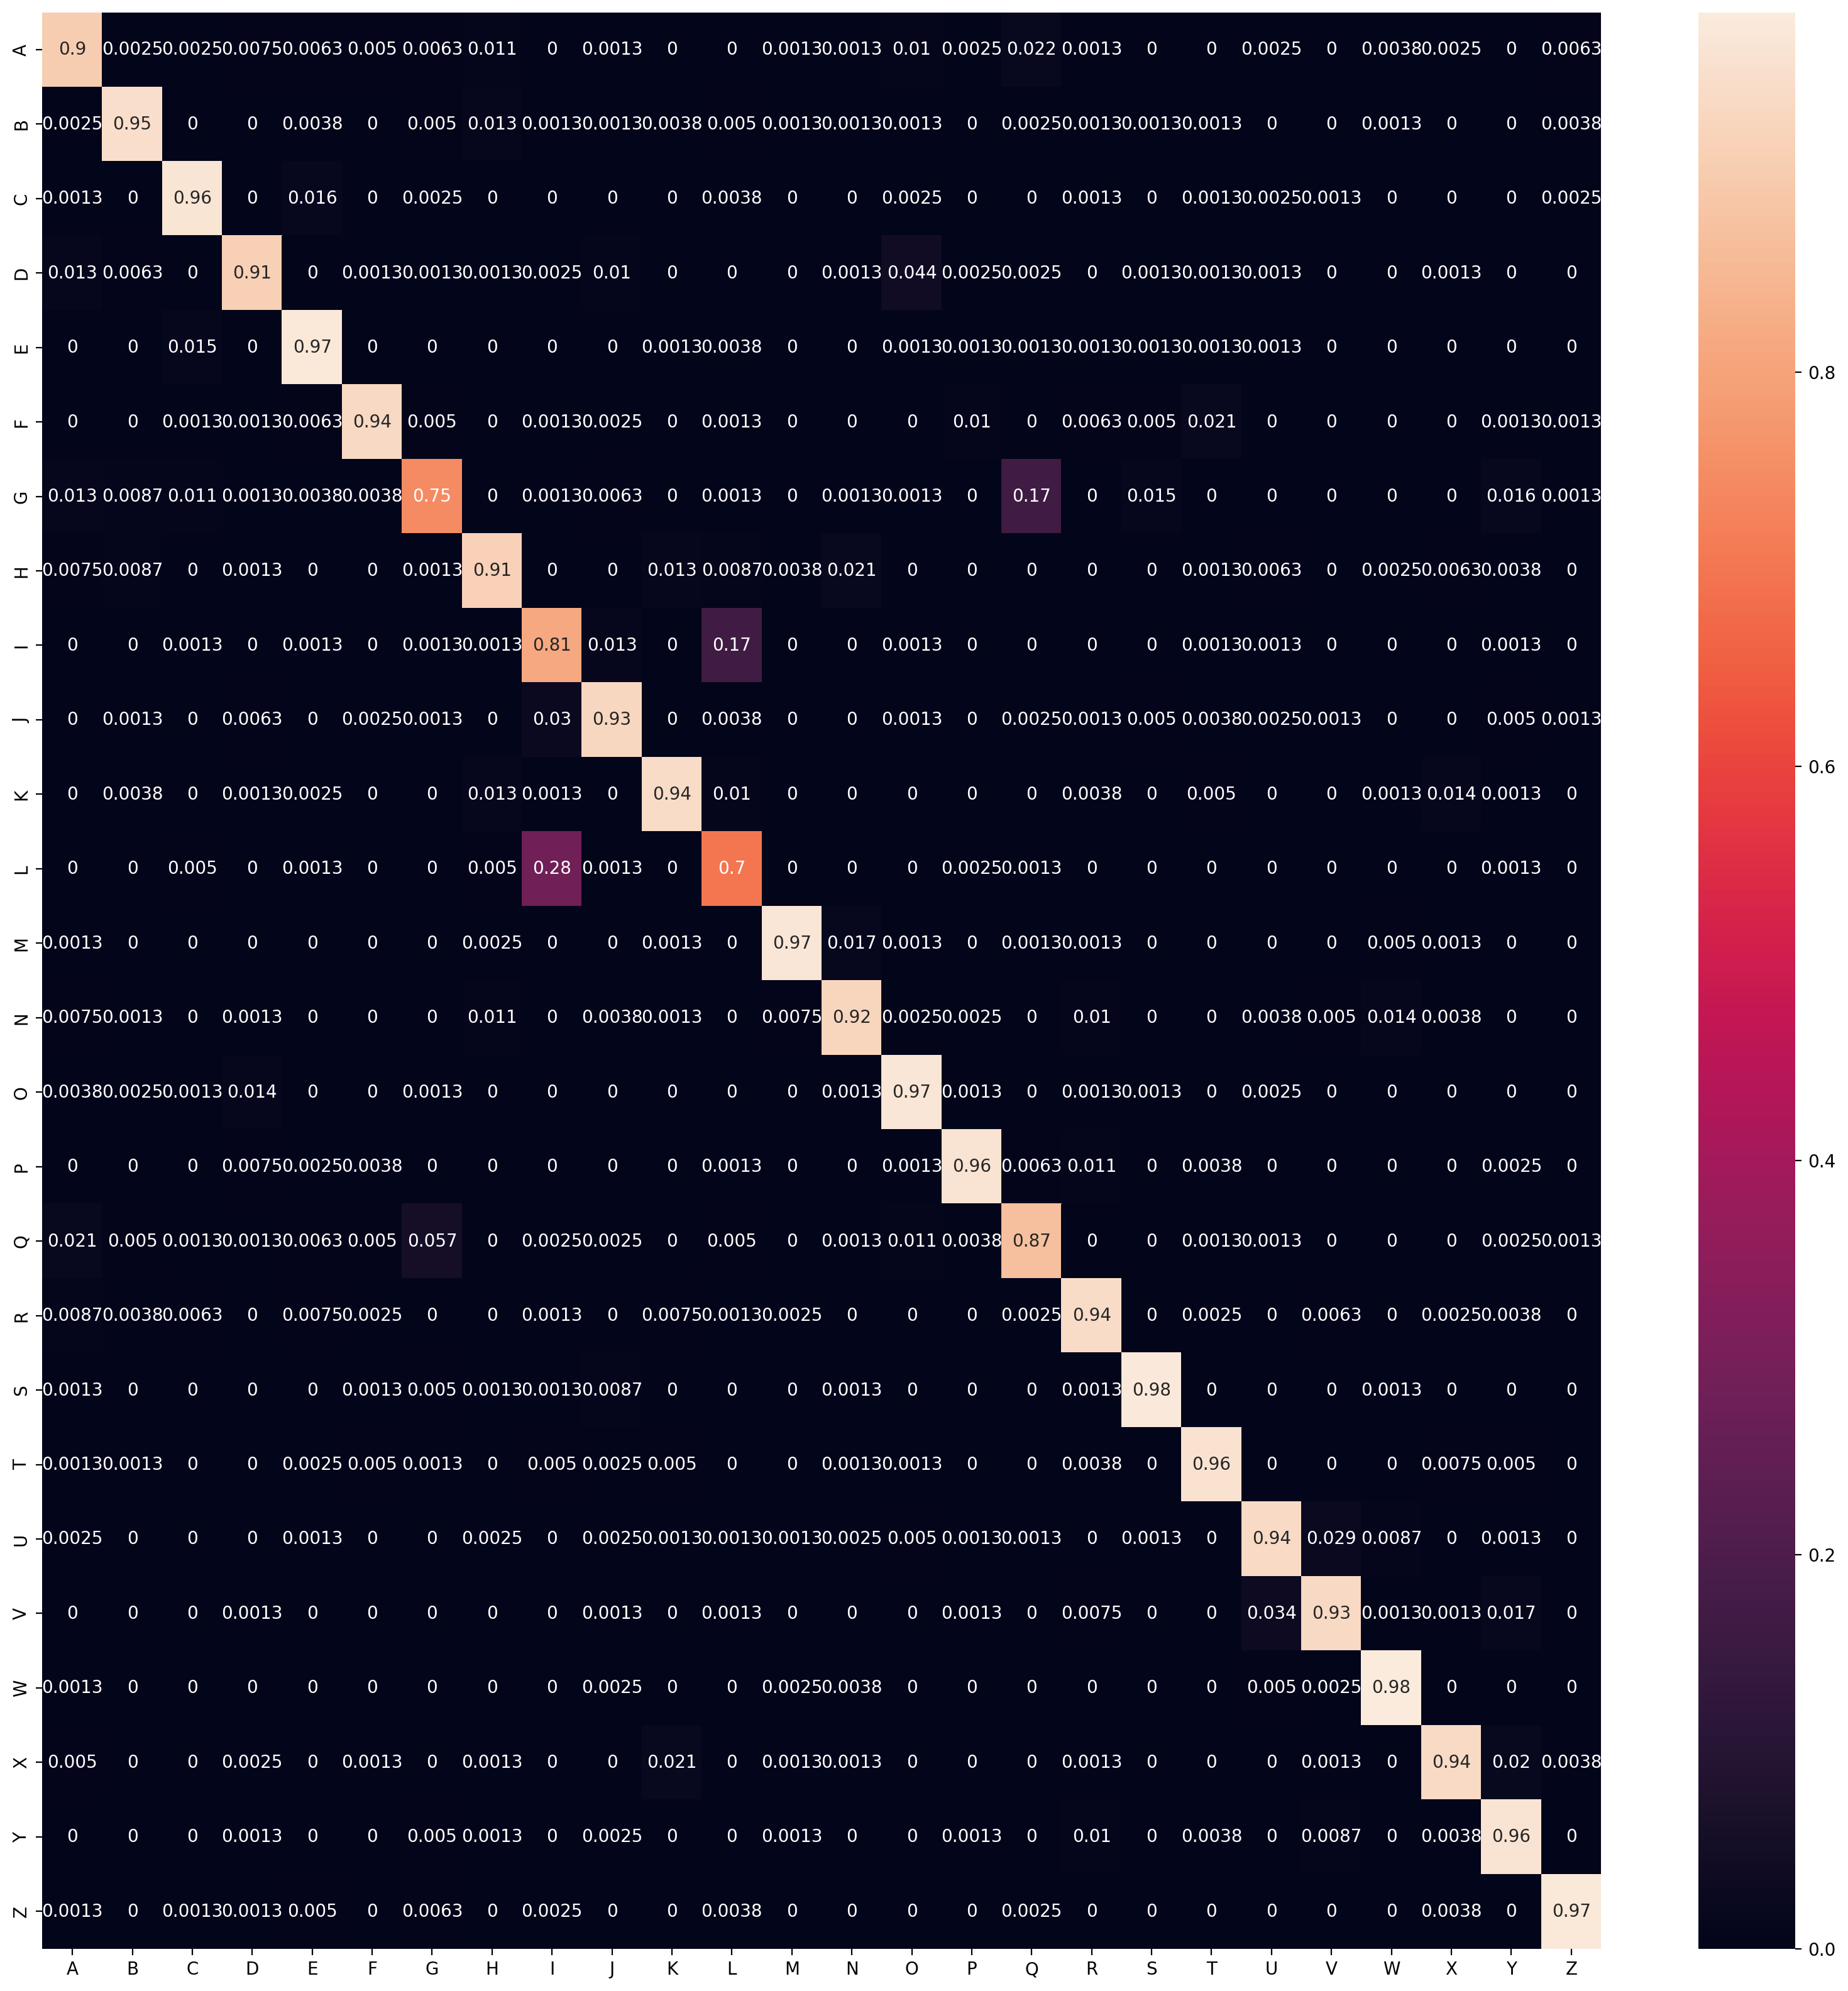

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in valid_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        output1 , output2 = model(inputs.unsqueeze(1)) # Feed Network

        output = (torch.max(torch.exp(torch.tensor(output1)), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *26, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')